# Machine Augmented Classification

The basic idea is to take advantage of underlying structure in an initially unlabelled data set.  Subjects are grouped into similar clusters based on proximity in feature space.

Volunteers can then decide what meaning each cluster has or if a cluster should be "dissolved".

Volunteers are provided with a list of predefined labels they can apply either to an entire cluster (assigning a meaning to the custer), or to individual subjects within a cluster ("dissolving" a cluster that groups subjects belonging to multiple classes).

After a pass over the data volunteers will have assigned labels to the data set.  An expert can review cluster labels and decide whether to merge or dissolve clusters based on domain knowledge.

A machine can be trained based on these labels.  The aim of this machine is to transform the data into a new feature space such that subjects from dissolved clusters now lie in distinct regions of the new feature space based on the new labels.  Well defined clusters may become even more tightly clustered in the new space.

Performance tracking can still be used here as volunteers label gold standard clusters or subsets of clusters or artificially contaminated clusters.

The labels that the machine is learning need not be exactly what the research team are looking for, but they can assign their own meaning on top of the volunteer labels.

Data sets that machines and humans are good at dealing with should fall out naturally.  A machine will naturally find it easy to classify classes that lie far from each other in feature space.  Humans will be good at identifying the "odd ones out" in clusters that confuse classes.

Jeremy Howard [TED talk](https://youtu.be/t4kyRyKyOpo?t=729) that captures the idea.

In [1]:
import os
import plotly
import numpy as np
import scipy.io as sio

In [2]:
# plotly.tools.set_credentials_file(username=os.environ["PLOTLY_USERNAME"], api_key=os.environ["PLOTLY_KEY"])

In [3]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

In [4]:
import matplotlib.pyplot as plt

Define a function for interactive data visualisation

In [5]:
def threeDPlot(X, indices, not_indices, label, not_label):
  trace1 = go.Scatter3d(
    x=X[indices,0],
    y=X[indices,1],
    z=X[indices,2],
    name=label,
    mode='markers',
    marker=dict(
      size=5,
      color='#1E2EDE',
      line=dict(
        color='rgb(204, 204, 204)',
        width=0.1
      ),
      opacity=0.8
    )
  )

  trace2 = go.Scatter3d(
    x=X[not_indices,0],
    y=X[not_indices,1],
    z=X[not_indices,2],
    name=not_label,
    mode='markers',
    marker=dict(
      color='#F5B841',
      size=5,
      symbol='circle',
      line=dict(
        color='rgb(204, 204, 204)',
        width=0.1
      ),
      opacity=0.8
    )
  )

  data = [trace1, trace2]

  layout = go.Layout(
    margin=dict(
      l=0,
      r=0,
      b=0,
      t=0
    )
  )
    
  fig = go.Figure(data=data, layout=layout)
  return fig

## mnist data set

Lets take the mnist data set as an example.

In [6]:
emnist = True

if emnist:
    mat = sio.loadmat("data/emnist-letters.mat")
    # load training data
    max_ = len(mat['dataset'][0][0][0][0][0][0])
    x_train_flattened = mat['dataset'][0][0][0][0][0][0][:max_]
    y_train = mat['dataset'][0][0][0][0][0][1][:max_]
    # Load testing data
    max_ = len(mat['dataset'][0][0][1][0][0][0])
    x_test = mat['dataset'][0][0][1][0][0][0][:max_]
    y_test = mat['dataset'][0][0][1][0][0][1][:max_]
    newsize = int(np.sqrt(x_train_flattened.shape[1]))
    x_train = np.reshape(x_train_flattened, (x_train_flattened.shape[0], newsize, newsize), "F")
else:
    from keras.datasets import mnist

    # Load pre-shuffled MNIST data into train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # flatten the images for PCA
    x_train_flattened = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

print(x_train_flattened.shape)
print(x_train.shape)

# limit the number of examples to 10000 so we can work with plotly interactive plots
x_train = x_train[:10000]
x_train_flattened = x_train_flattened[:10000]
y_train = y_train[:10000]

(124800, 784)
(124800, 28, 28)


User PCA to project this data into 3 dimensions so we can visualise it.

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train_flattened)

Visualise the data singling out images labelled zero.

In [9]:
# fig = threeDPlot(x_train_pca, np.where(y_train==0)[0], np.where(y_train!=0)[0], '0', 'not 0')
# py.iplot(fig, filename='mnist_pca3_label0')

Use heirarchical clustering (which is unsupervised) to group the subjects based on euclidean distance in the original 784 dimensional pixel space.  Choose 100 clusters for no particular reason. 

In [10]:
from sklearn.cluster import AgglomerativeClustering

In [11]:
n_clusters = 100
clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering.fit(x_train_flattened)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=100,
            pooling_func=<function mean at 0x00000283042C3E18>)

In [12]:
from keras.utils import np_utils

try:
  del x_labelled
except NameError:
  pass

one_hot_encoded = np_utils.to_categorical(y_train, 27)

for cluster in range(n_clusters):
  cluster_indices = np.where(clustering.labels_ == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  dominant_cluster_class = np.argmax(cluster_label_fractions)
  print(cluster, n_assigned_examples, dominant_cluster_class, cluster_label_fractions[dominant_cluster_class])
  # assign labels based on >= 90% class membership, mimicing human labelling
  # I'm assuming that if a cluster is diminated by a singel class volunteers 
  # will assign that class to it.
  if cluster_label_fractions[dominant_cluster_class] >= 0.9:
    x = x_train[cluster_indices]
    l = np.zeros((x.shape[0], 27))
    l[:,dominant_cluster_class] += 1
    try:
      x_labelled = np.concatenate((x_labelled, x))
      labels = np.concatenate((labels, l))
      labelled_indices = np.concatenate((labelled_indices, cluster_indices))
    except NameError:
      x_labelled = x
      labels = l
      labelled_indices = cluster_indices
        
print(x_labelled.shape)
print(labels.shape)

m = x_labelled.shape[0]
order = np.random.permutation(m)
x_labelled = x_labelled[order]
x_labelled = x_labelled[:,:,:,np.newaxis]
labels = labels[order]

unlabelled_indices = np.array([x for x in range(x_train.shape[0]) if x not in labelled_indices])

Using TensorFlow backend.


0 109 11 0.724770642202
1 181 21 0.635359116022
2 331 9 0.441087613293
3 112 8 0.303571428571
4 141 10 0.695035460993
5 201 6 0.482587064677
6 129 19 0.635658914729
7 136 6 0.323529411765
8 88 3 0.465909090909
9 170 16 0.317647058824
10 142 11 0.661971830986
11 94 24 0.68085106383
12 107 18 0.560747663551
13 135 20 0.503703703704
14 189 13 0.978835978836
15 137 4 0.525547445255
16 91 5 0.571428571429
17 114 19 0.991228070175
18 131 4 0.595419847328
19 126 22 0.730158730159
20 223 9 0.354260089686
21 86 24 0.779069767442
22 125 14 0.472
23 90 4 0.2
24 88 3 0.704545454545
25 89 1 0.47191011236
26 86 17 0.860465116279
27 127 13 0.370078740157
28 101 23 0.910891089109
29 111 26 0.954954954955
30 101 17 0.475247524752
31 101 26 0.90099009901
32 190 1 0.389473684211
33 126 23 0.825396825397
34 47 16 0.468085106383
35 80 2 0.425
36 145 16 0.510344827586
37 127 15 0.409448818898
38 167 8 0.449101796407
39 96 2 0.53125
40 68 7 0.367647058824
41 98 18 0.520408163265
42 111 7 0.261261261261
43 98

The cluster id, number of examples assigned to each cluster, the dominant cluster class and the proportion of the cluster belonging to the dominant cluster class are printed out.

To replicate volunteer labelling of each class, if the dominant cluster class makes up more than 90% of the cluster then assign the dominant cluster label to that cluster.  This is the same as assuming that if 90% of the data is of one class a volunteer will assign it the label corresponding to 90% of the data in the cluster.

This gives us a data set of 6943 labelled examples.  There is an upper limit on the label contamination in this data set of 10%.

Define some functions to visualise the data assigned to each cluster.

In [13]:
def getDimensions(n):
  dim = int(np.ceil(np.sqrt(n)))
  return (dim, dim)

In [14]:
def plotCluster(cluster_labels, cluster, X, image_dim, limit=200, cmap='gray_r'):
  indices = np.where(cluster_labels == cluster)[0] # get the examples assigned to cluster 0

  n = np.where(cluster_labels == cluster)[0].shape[0]
  print(n)
  if n > limit:
    indices = indices[:limit]
    n = limit
    
  dims = getDimensions(n)
    
  fig = plt.figure(figsize=(20,20))
  for i in range(n):
    ax = fig.add_subplot(dims[0],dims[1],i+1)
    ax.imshow(np.reshape(X[indices[i]], (image_dim,image_dim), order='F'), cmap=cmap)
    plt.axis('off')
  plt.show()

Visualise cluster 29 containing 111 subjects with 95% labelled 26 ("Z").

111


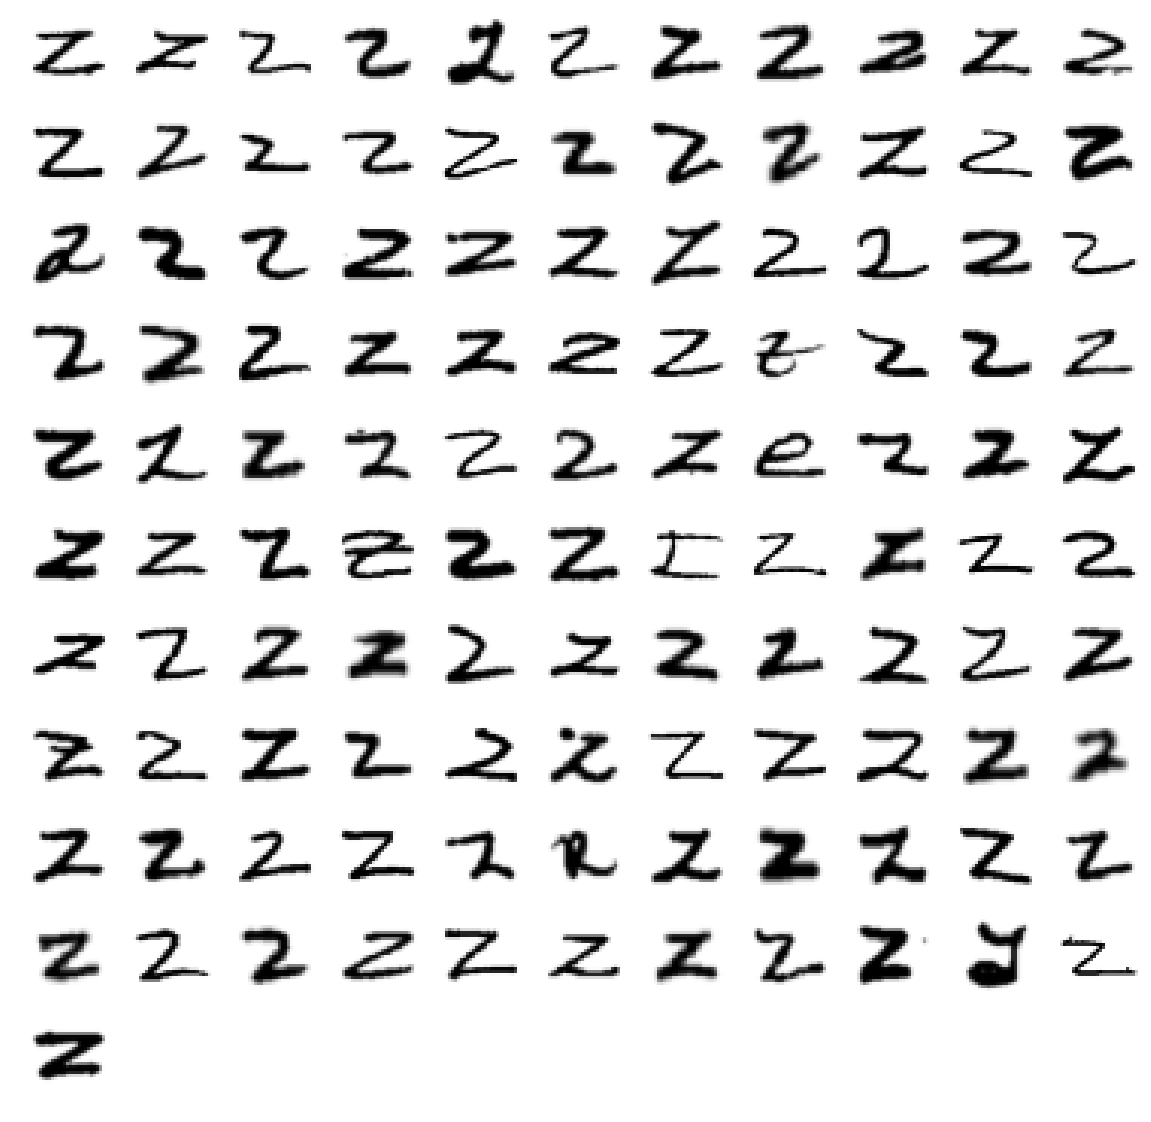

In [15]:
plotCluster(clustering.labels_, 29, x_train_flattened, 28)

Visualise cluster 79 containing 74 subjects with 98% labelled 23 ("W").

74


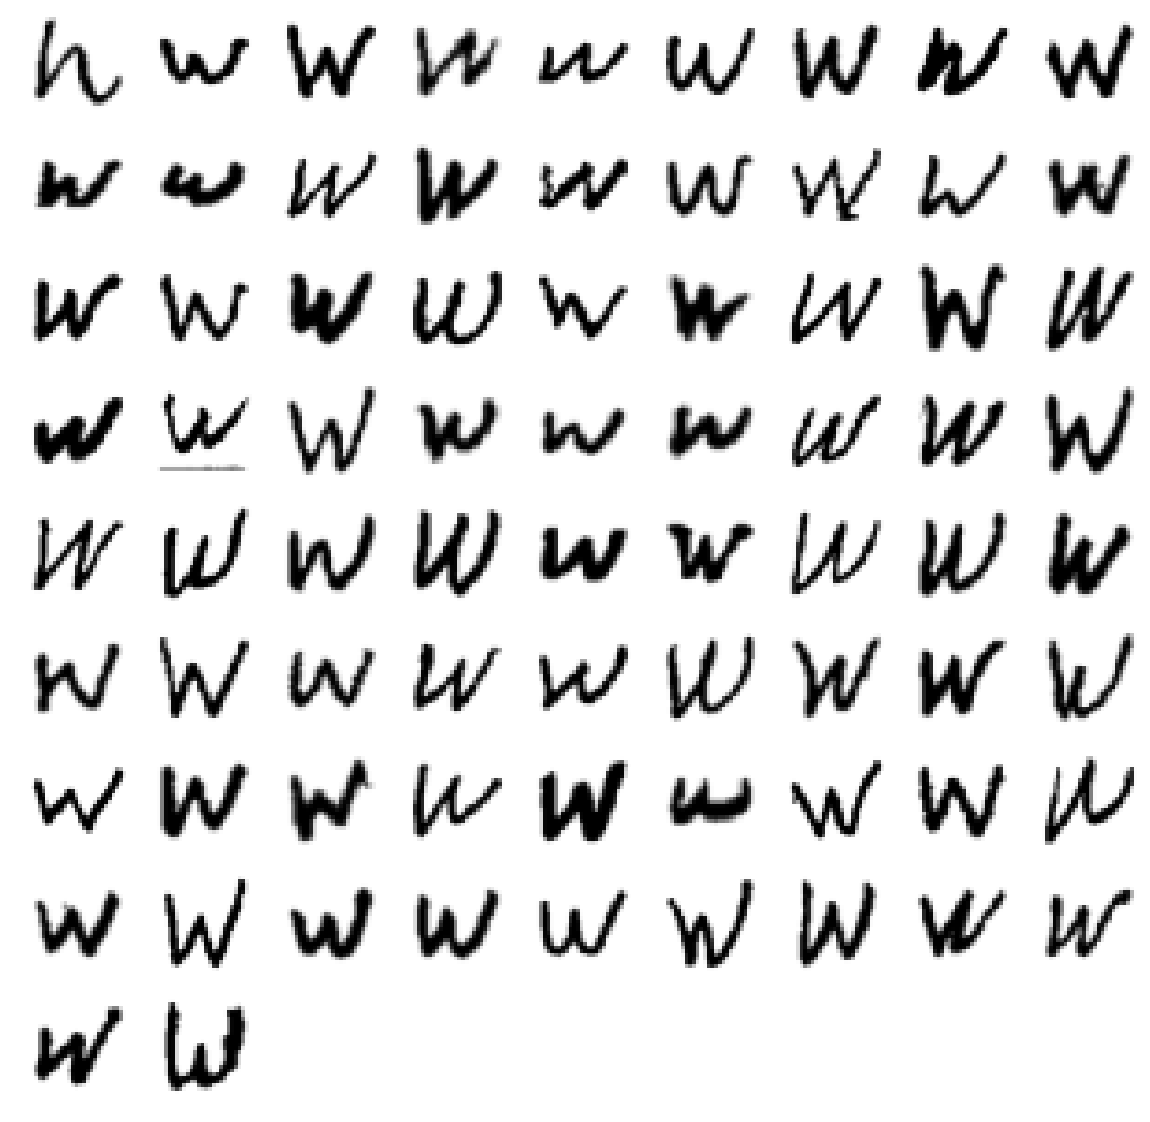

In [16]:
plotCluster(clustering.labels_, 79, x_train_flattened, 28)

Visualise cluster 12 containing 107 subjects with 56% labelled 18 ("R").

107


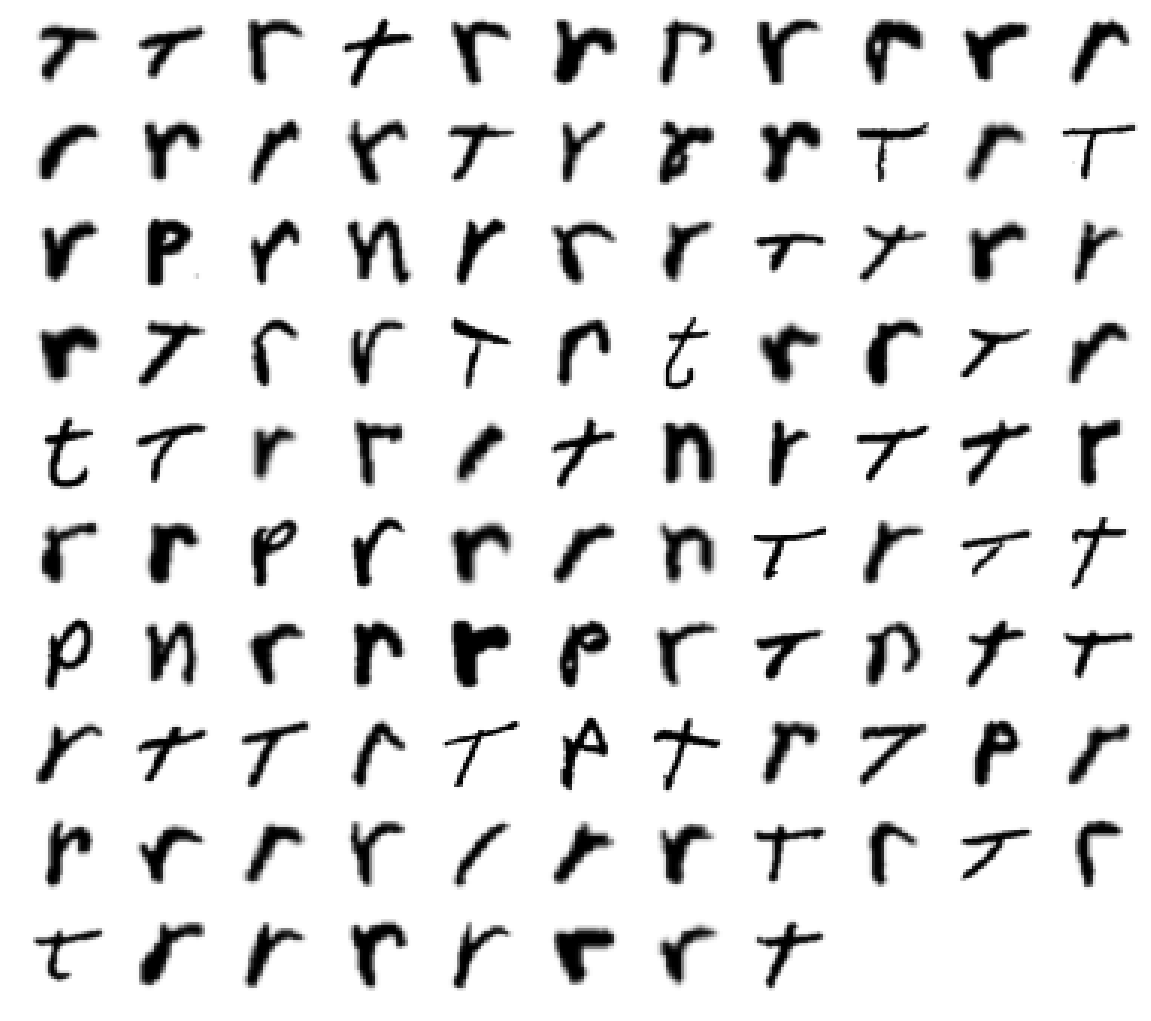

In [17]:
plotCluster(clustering.labels_, 12, x_train_flattened, 28)

Visualise cluster 87 containing 135 subjects with 51% labelled 9 ("I"). 

135


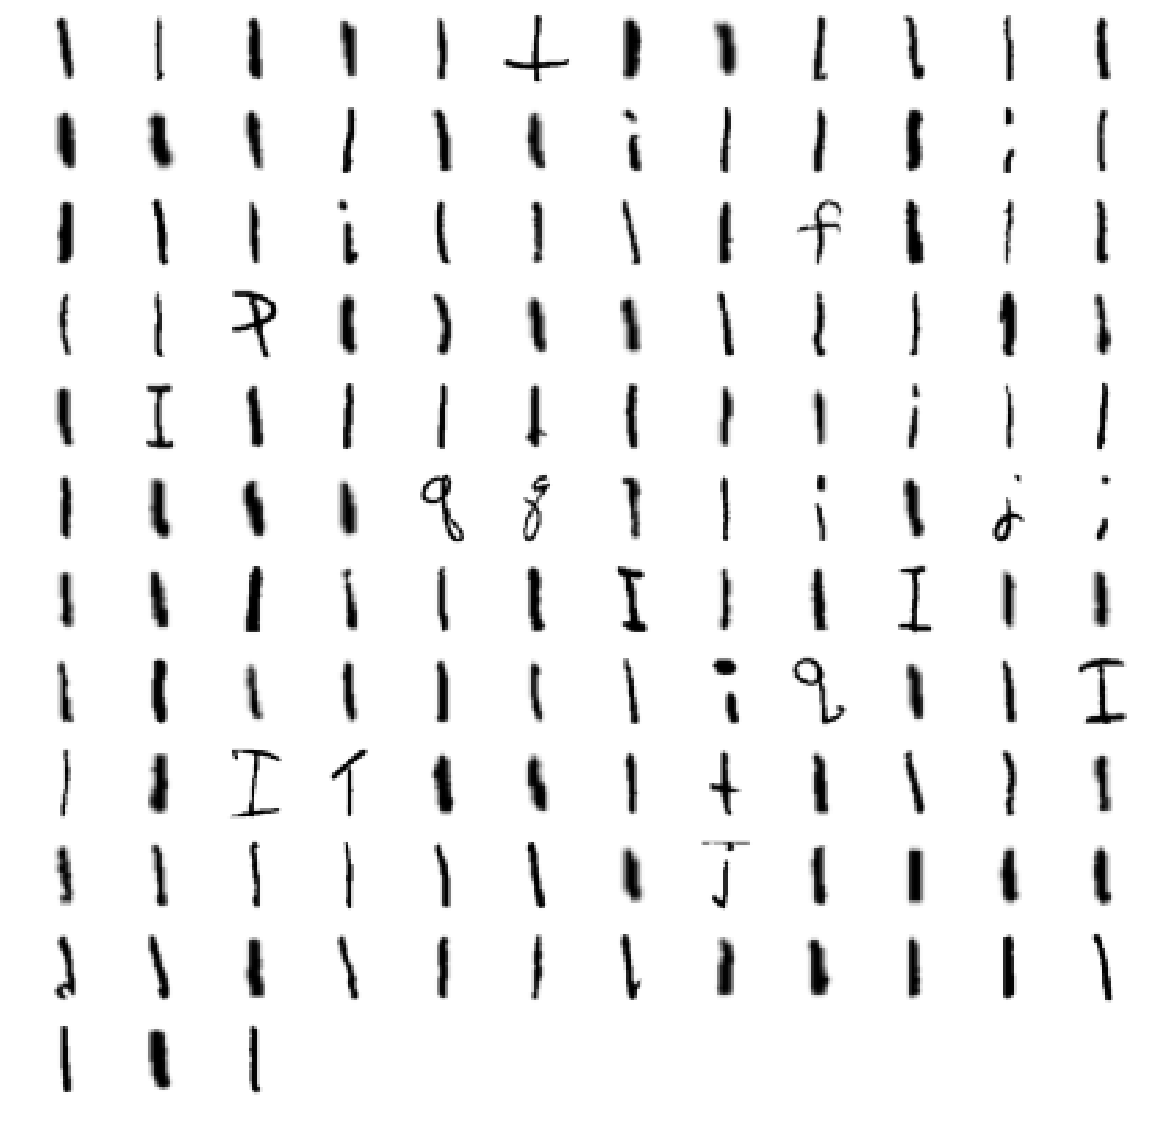

In [18]:
plotCluster(clustering.labels_, 87, x_train_flattened, 28)

Train a machine to classify the labelled data set.

Using a CNN here, but other architectures might be better.

In [19]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [20]:
def calculateAccuracy(model, x, y, n_classes):
  preds = model.predict(x)
  return 100*np.sum(np.argmax(preds, axis=1)== np.argmax(np_utils.to_categorical(y, n_classes), axis=1))/ len(preds)

In [21]:
# build the CNN
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', \
                   activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D('channels_last'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [22]:
# fit the model to the data
model.fit(x_labelled, labels, epochs=20, batch_size=500)

Epoch 1/20
6943/6943 [==============================] - 3s - loss: 10.9824     
Epoch 2/20
6943/6943 [==============

In [23]:
# determine if test set classes are balanced
print(np.sum(np_utils.to_categorical(y_test, 10), axis=0)/np.sum(np_utils.to_categorical(y_test, 10)))

[ 0.098   0.1135  0.1032  0.101   0.0982  0.0892  0.0958  0.1028  0.0974
  0.1009]


Calculate the accuracy of this classifier on the test set

In [24]:
test_accuracy = calculateAccuracy(model, x_test[:,:,:,np.newaxis], y_test, 10)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 61.8600%


Determine the effect of running this classifier for double the number of epochs.  This is important for later as we want to ensure that any future imporvements to this model are not just because we add epochs.

In [25]:
# clone the above model and load its weights after 20 epochs
model2 = Sequential()
model2.add(Conv2D(filters=16, kernel_size=2, padding='valid', \
                    activation='relu', input_shape=(28,28,1), \
                    weights=model.layers[0].get_weights())) # load the learned weights from the previous model
model2.add(MaxPooling2D(pool_size=2))
model2.add(Conv2D(filters=32, kernel_size=2, padding='valid', \
                    activation='relu',weights=model.layers[2].get_weights()))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Conv2D(filters=64, kernel_size=2, padding='valid', \
                    activation='relu',weights=model.layers[4].get_weights()))
model2.add(MaxPooling2D(pool_size=2))
model2.add(GlobalAveragePooling2D('channels_last'))
model2.add(Dense(10, activation='softmax', weights=model.layers[7].get_weights()))
model2.compile(loss='categorical_crossentropy', optimizer='adam')

In [26]:
# train the cloned mode for an additional 20 epochs
model2.fit(x_labelled, labels, epochs=20, batch_size=500)

Epoch 1/20
6943/6943 [==============================] - 3s - loss: 4.3243     
Epoch 2/20
6943/6943 [============================

In [27]:
test_accuracy = calculateAccuracy(model2, x_test[:,:,:,np.newaxis], y_test, 10)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 64.9900%


Make a clone of the original model striping off the output layer so we can project data into the feature space learned by the CNN.

In [96]:
# make a clone of the model above stripping off the output layer and loading the 
# trained weights after 20 epochs
model3 = Sequential()
model3.add(Conv2D(filters=16, kernel_size=2, padding='valid', \
                    activation='relu', input_shape=(28,28,1), \
                    weights=model.layers[0].get_weights())) # load the learned weights from the previous model
model3.add(MaxPooling2D(pool_size=2))
model3.add(Conv2D(filters=32, kernel_size=2, padding='valid', \
                    activation='relu',weights=model.layers[2].get_weights()))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Conv2D(filters=64, kernel_size=2, padding='valid', \
                    activation='relu',weights=model.layers[4].get_weights()))
model3.add(MaxPooling2D(pool_size=2))
model3.add(GlobalAveragePooling2D('channels_last'))

Project the entire data set (10000 subjects) into the CNN feature space.

In [97]:
activations = model3.predict(x_train[:,:,:,np.newaxis]) # encode the images
print(activations.shape)

(10000, 64)


Reduce this feature representation to 3 dimensions for visualisation.

In [98]:
pca = PCA(n_components=3)
activations_pca = pca.fit_transform(activations)

Plot the original data set transformed into the new feature space, distinguishing subjects that were labelled form those that remain unlabelled.

In [31]:
fig = threeDPlot(activations_pca, labelled_indices, unlabelled_indices, 'labelled', 'unlabelled')
py.iplot(fig, filename='mnist_activations_pca3_labelled')

Now perform the clustering again in the new feature space again arbitrarily looking for 100 clusters.

In [99]:
clustering_activations = AgglomerativeClustering(n_clusters=n_clusters)
clustering_activations.fit(activations)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=100,
            pooling_func=<function mean at 0x10528f950>)

In [100]:
for cluster in range(n_clusters):
  cluster_indices = np.where(clustering_activations.labels_ == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  dominant_cluster_class = np.argmax(cluster_label_fractions)
  print(cluster, n_assigned_examples, dominant_cluster_class, cluster_label_fractions[dominant_cluster_class])
  # assign labels based on >= 90% class membership, mimicing human labelling
  if cluster_label_fractions[dominant_cluster_class] >= 0.9:
    a = activations[cluster_indices]
    l = np.zeros((a.shape[0], 10))
    l[:,dominant_cluster_class] += 1
    try:
      a_labelled = np.concatenate((a_labelled, a))
      labels = np.concatenate((labels, l))
      labelled_indices = np.concatenate((labelled_indices, cluster_indices))
    except NameError:
      a_labelled = a
      labels = l
      labelled_indices = cluster_indices
        
print(a_labelled.shape)
print(labels.shape)

m = a_labelled.shape[0]
order = np.random.permutation(m)
a_labelled = a_labelled[order]
labels = labels[order]

unlabelled_indices = np.array([x for x in range(x_train.shape[0]) if x not in labelled_indices])

0 100 3 0.57
1 116 9 0.827586206897
2 125 2 0.624
3 85 7 0.964705882353
4 214 1 0.995327102804
5 154 5 0.967532467532
6 254 6 1.0
7 139 4 0.856115107914
8 167 4 0.976047904192
9 176 2 0.755681818182
10 132 3 0.674242424242
11 73 7 0.986301369863
12 108 0 0.981481481481
13 76 0 0.552631578947
14 83 7 0.78313253012
15 148 7 0.912162162162
16 83 3 0.674698795181
17 119 0 0.924369747899
18 115 7 0.973913043478
19 126 3 1.0
20 180 8 0.866666666667
21 77 1 0.987012987013
22 160 4 0.98125
23 119 2 0.957983193277
24 43 6 0.883720930233
25 84 4 0.797619047619
26 127 5 0.842519685039
27 174 8 0.431034482759
28 198 8 0.989898989899
29 68 2 0.294117647059
30 123 1 0.991869918699
31 88 7 0.443181818182
32 197 1 1.0
33 108 4 0.916666666667
34 58 9 0.258620689655
35 85 9 0.894117647059
36 112 8 0.660714285714
37 65 2 0.553846153846
38 61 3 0.704918032787
39 127 5 0.889763779528
40 64 6 0.71875
41 96 3 1.0
42 131 6 0.977099236641
43 87 2 0.735632183908
44 60 0 0.983333333333
45 138 9 0.876811594203
46

The same as before the clusters with great than 90% dominant class membership are assinged the label of the dominant class.  The previous set of labels have been forgotten, but a mechanism to take advantage those might help.  This time we get a labelled training set with 4974 subjects.

Visualise some of these clusters.

Cluster 0 with 151 subjects and 99% labelled 4.

78


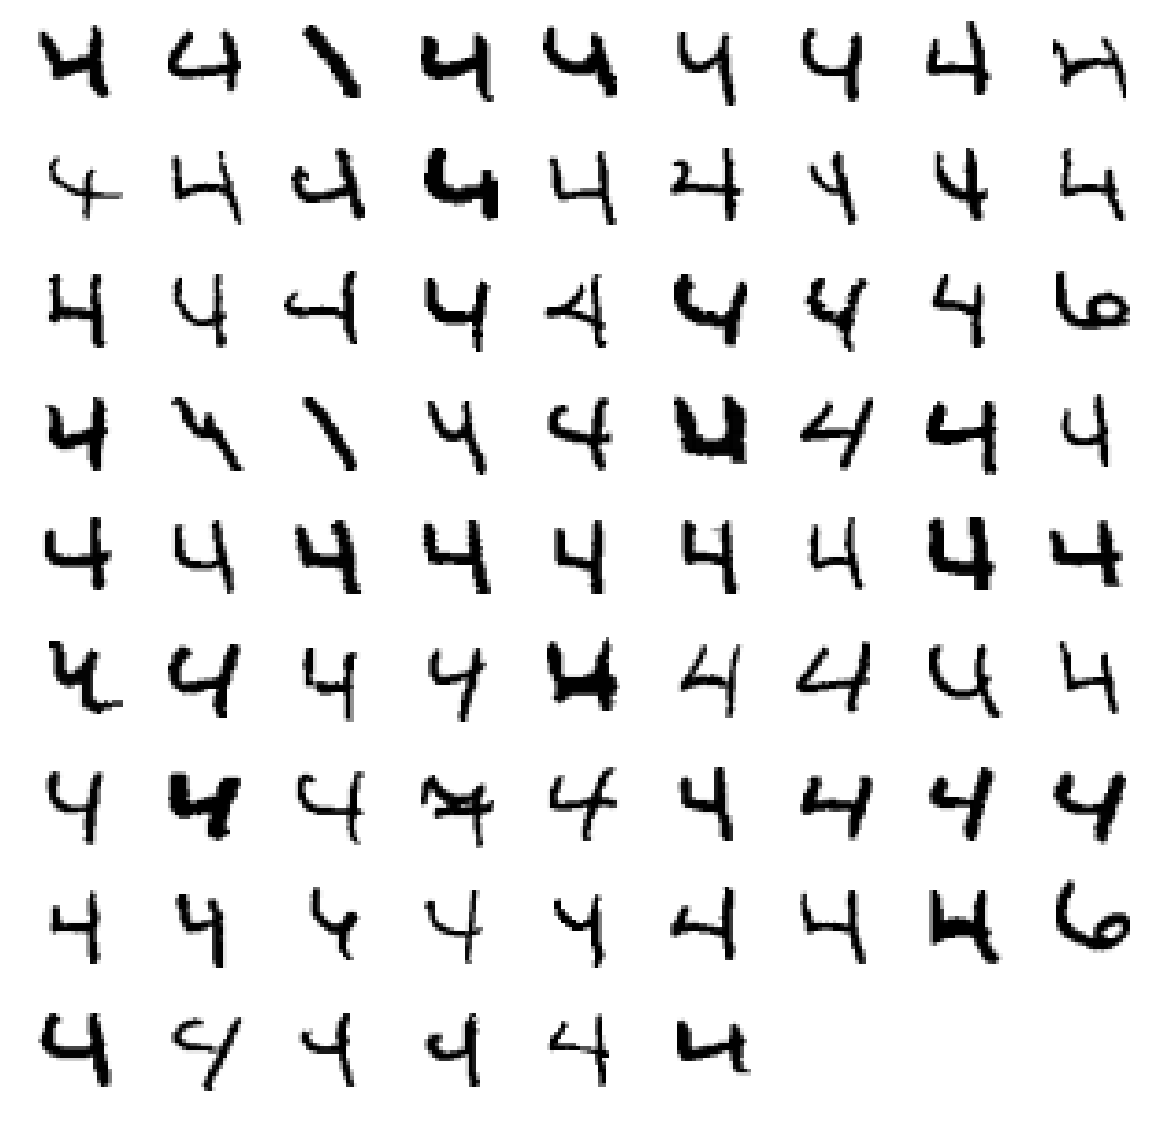

In [34]:
plotCluster(clustering_activations.labels_, 0, x_train, 28)

Cluster 36 with 100 subject 29% labelled 8

128


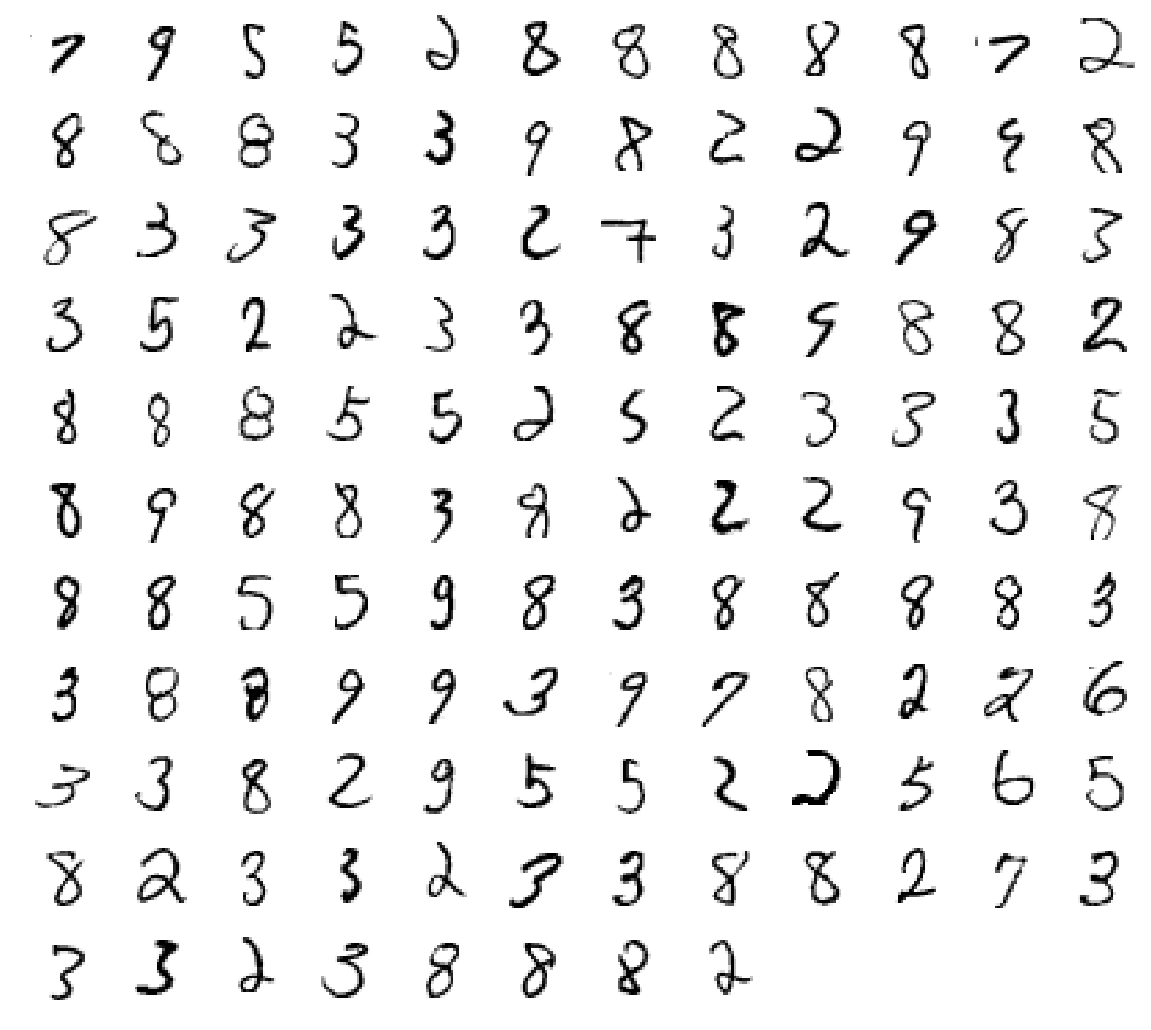

In [35]:
plotCluster(clustering_activations.labels_, 36, x_train, 28)

In [36]:
model4 = Sequential()
model4.add(Dense(500, activation='relu', input_shape=(activations.shape[1],)))
model4.add(Dense(10, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam')

In [37]:
# fit the model to the data
model4.fit(a_labelled, labels, epochs=20, batch_size=500)

Epoch 1/20
4154/4154 [==============================] - 0s - loss: 4.4550     
Epoch 2/20
4154/4154 [==============================] - 0s - loss: 2.3642     
Epoch 3/20
4154/4154 [==============================] - 0s - loss: 1.8287     
Epoch 4/20
4154/4154 [==============================] - 0s - loss: 1.6158     
Epoch 5/20
4154/4154 [==============================] - 0s - loss: 1.5074     

In [95]:
test_activations = model3.predict(x_test[:,:,:,np.newaxis])
test_accuracy = calculateAccuracy(model4, test_activations, y_test, 10)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 66.5000%


This is an improvement on the 62% achieved above. This suggests that the data has been transformed into a more discriminant feature space.  Although model4 is trained on ~2000 fewer subjects than model2 it is 18% more accurate.

Confused clusters such as cluster 36 visualised above would be an example of a cluster to dissolve.  Volunteers would be asked to assign a label to each subject in the cluster if the cluster did not appear to capture anything sinificant.

## 3Pi image data

Lets try this with the PS1 3pi data set.

This is more difficult.  The data is labelled into two classes but there is more underlying structure such as different artefact types and signal-to-noise.  The classes are skewed to 3 times more bogus than real, MNIST classes are balanced.

In [39]:
path = '/Users/dwright/dev/zoo/data/'
file = '3pi_20x20_skew2_signPreserveNorm.mat'
data = sio.loadmat(path+file)

In [40]:
x_train = data['X'] # load the pixel data
y_train = np.squeeze(data['y']) # load the targets
x_test  = data['testX'] # load the pixel data
y_test  = np.squeeze(data['testy']) # load the targets

Cluster subjects into 20 groups using heirarchical clustering

In [41]:
n_clusters = 20
clustering_threepi = AgglomerativeClustering(n_clusters=n_clusters)
clustering_threepi.fit(x_train)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=20,
            pooling_func=<function mean at 0x10528f950>)

In [42]:
del x_labelled
one_hot_encoded = np_utils.to_categorical(y_train, 2)

for cluster in range(n_clusters):
  cluster_indices = np.where(clustering_threepi.labels_ == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  dominant_cluster_class = np.argmax(cluster_label_fractions)
  print(cluster, n_assigned_examples, dominant_cluster_class, cluster_label_fractions[dominant_cluster_class])
  # assign labels based on >= 95% class membership, mimicing human labelling
  # I'm assuming that if a cluster is diminated by a singel class volunteers 
  # will assign that class to it.
  if cluster_label_fractions[dominant_cluster_class] >= 0.95:
    x = x_train[cluster_indices]
    if dominant_cluster_class == 0:
      l = np.zeros((x.shape[0],))
    elif dominant_cluster_class == 1:
      l = np.ones((x.shape[0],))
    else:
        raise ValueError
    # save the indices for cluster 7. We'll use these below.
    try:
      x_labelled = np.concatenate((x_labelled, x))
      labels = np.concatenate((labels, l))
      labelled_indices = np.concatenate((labelled_indices, cluster_indices))
    except NameError:
      x_labelled = x
      labels = l
      labelled_indices = cluster_indices

m = x_labelled.shape[0]
order = np.random.permutation(m)
x_labelled = x_labelled[order]
x_labelled = np.reshape(x_labelled, (m,20,20), order='F')
x_labelled = x_labelled[:,:,:,np.newaxis]
labels = labels[order]

print(x_labelled.shape)
print(labels.shape)

unlabelled_indices = np.array([x for x in range(x_train.shape[0]) if x not in labelled_indices])

0 113 0 1.0
1 232 0 0.991379310345
2 980 0 0.531632653061
3 1264 1 0.559335443038
4 230 0 0.986956521739
5 175 0 1.0
6 308 0 0.961038961039
7 309 1 0.556634304207
8 1004 1 0.699203187251
9 127 0 0.984251968504
10 525 0 0.864761904762
11 163 0 0.993865030675
12 297 0 0.895622895623
13 518 0 0.781853281853
14 107 0 0.943925233645
15 107 0 0.971962616822
16 154 0 0.915584415584
17 70 0 0.9
18 147 0 0.979591836735
19 86 0 1.0
(1688, 20, 20, 1)
(1688,)


Assign a more stringent label assignment criteria based on 95% dominant class membership for this data set as there are only 2 classes.  In MNIST cluster contamination was likelt a mixture of a subset of the other 9 classes.

This creates a labelled training set of 1688 subjects, but no cluster with >= 95% class membership has a label of real.  We therefore can't train a machine.  We need to explore the cluster dissolving step.

Visualise some of these clusters

Cluster 0 with 113 subjects and 100% bogus subject membership

113


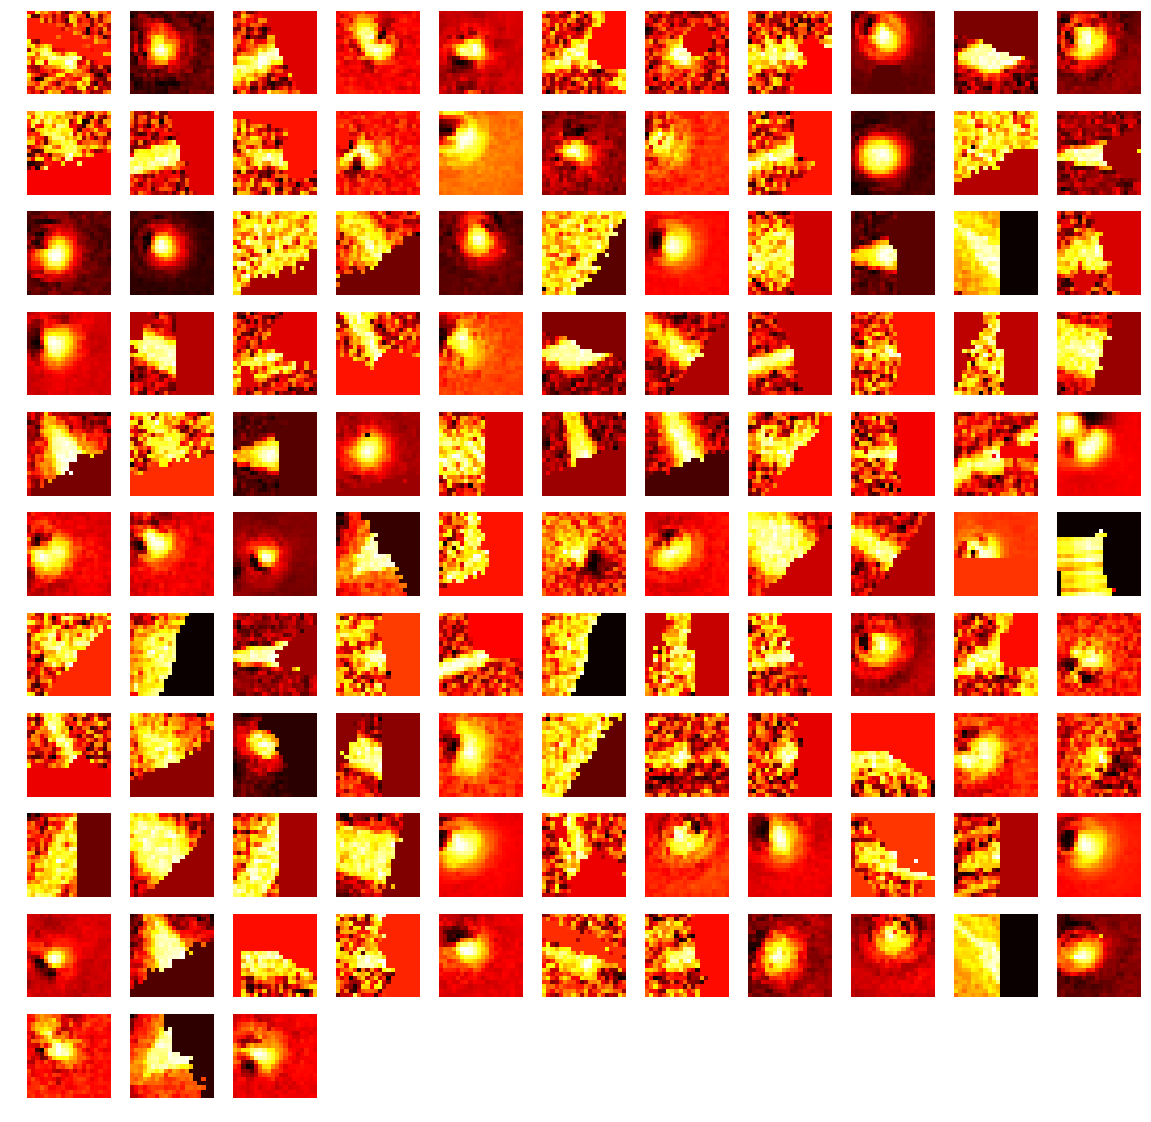

In [43]:
plotCluster(clustering_threepi.labels_, 0, x_train, 20, cmap='hot')

This cluster could be labelled bogus or 'high signal-to-noise artefacts'.  Or although this cluster contains 100% bogus subjects it might be worth dissolving it further into 2 further classes something like 'masked on the right hand side' and 'saturated source subtraction off centre to the left'.  These classes could be easier for the machine to learn, while an expert could assign a label of bogus to each of these classes without the mamchine having to try and force these into the same output neuron.

Visualise cluster 3 with 1264 sbjects 56% of which are labelled real.

1264


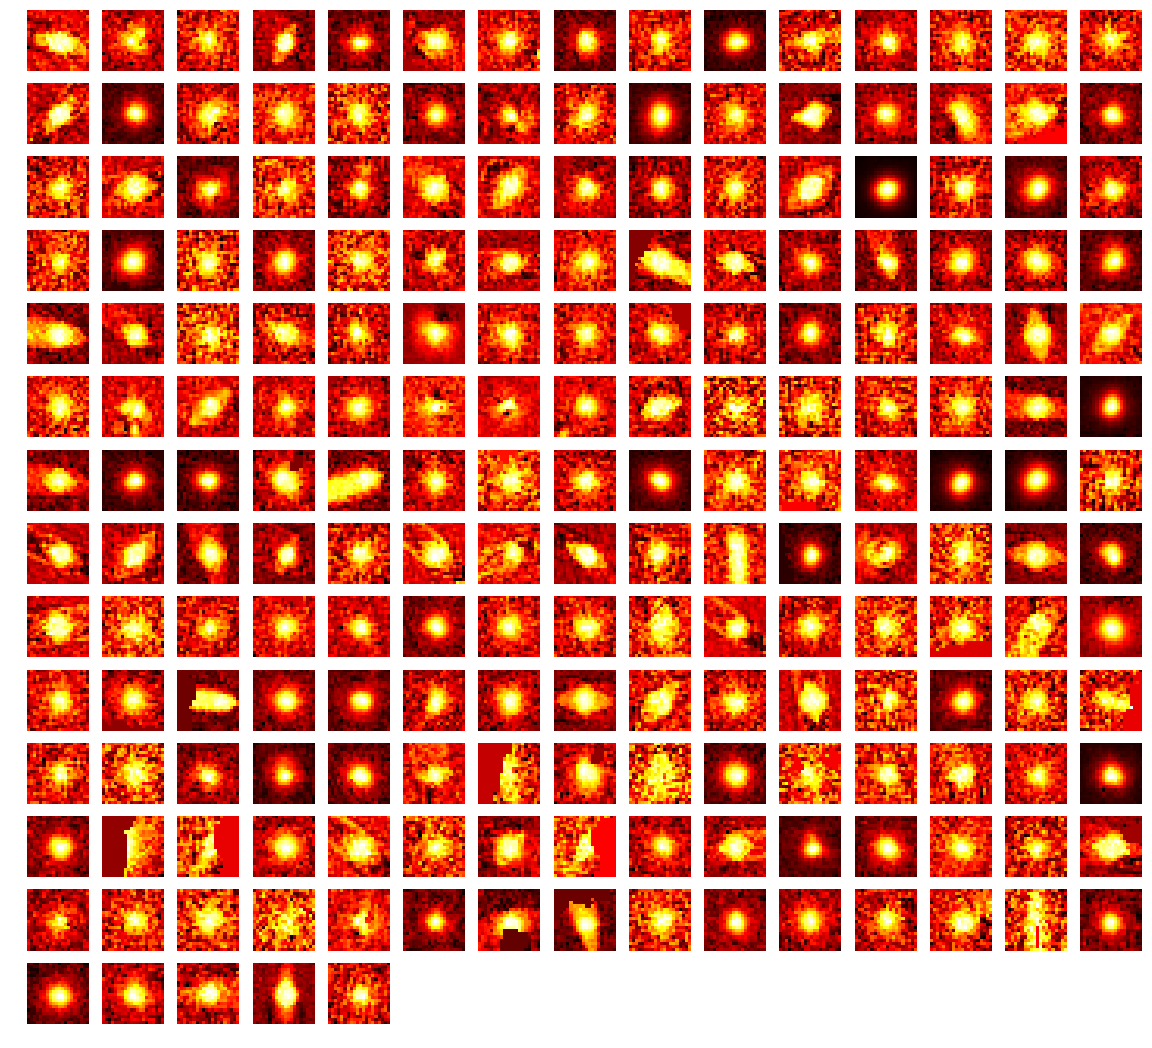

In [44]:
plotCluster(clustering_threepi.labels_, 3, x_train, 20, cmap='hot')

This cluster could be dissolved based on labels of 'real' and  'burntool artefact'.

For now, to approximate the process of dissolving a cluster we use the labels of real and bogus to dissolve some of the most confused clusters.  Add a small amount of label noise to replicate volunteer errors.

In [45]:
def askClusterLabels(cluster_labels, cluster, X, y, image_dims=None, noise_level=None):
  cluster_indices = np.where(cluster_labels == cluster)[0]
  m = cluster_indices.shape[0]
  if image_dims:
    x = np.reshape(X[cluster_indices], (m, image_dims[0], image_dims[1]), order='F')
    x = x[:,:,:,np.newaxis]
  else:
    x = X[cluster_indices]
  cluster_labels = y_train[cluster_indices]
  if noise_level:
    # add some random noise to these labels 
    slice = np.random.permutation(m)[:int(noise_level*m)]
    cluster_labels[slice] = cluster_labels[slice] != 1
  return x, cluster_labels, cluster_indices

In [46]:
noise_level=0.1

x, cluster_labels, cluster_indices = askClusterLabels(clustering_threepi.labels_, 
                                                      2,
                                                      x_train, 
                                                      y_train, 
                                                      (20, 20),
                                                      noise_level
                                                     )

labelled_indices = np.concatenate((labelled_indices, cluster_indices))
x_labelled = np.concatenate((x_labelled, x))
labels = np.concatenate((labels, cluster_labels))

x, cluster_labels, cluster_indices = askClusterLabels(clustering_threepi.labels_, 
                                                      3, 
                                                      x_train, 
                                                      y_train, 
                                                      (20, 20),
                                                      noise_level
                                                     )

labelled_indices = np.concatenate((labelled_indices, cluster_indices))
x_labelled = np.concatenate((x_labelled, x))
labels = np.concatenate((labels, cluster_labels))

x, cluster_labels, cluster_indices = askClusterLabels(clustering_threepi.labels_, 
                                                      7, 
                                                      x_train, 
                                                      y_train, 
                                                      (20, 20),
                                                      noise_level
                                                     )

labelled_indices = np.concatenate((labelled_indices, cluster_indices))
x_labelled = np.concatenate((x_labelled, x))
labels = np.concatenate((labels, cluster_labels))

x, cluster_labels, cluster_indices = askClusterLabels(clustering_threepi.labels_, 
                                                      8, 
                                                      x_train, 
                                                      y_train, 
                                                      (20, 20),
                                                      noise_level
                                                     )

labelled_indices = np.concatenate((labelled_indices, cluster_indices))
x_labelled = np.concatenate((x_labelled, x))
labels = np.concatenate((labels, cluster_labels))

x, cluster_labels, cluster_indices = askClusterLabels(clustering_threepi.labels_, 
                                                      13, 
                                                      x_train, 
                                                      y_train, 
                                                      (20, 20),
                                                      noise_level
                                                     )

labelled_indices = np.concatenate((labelled_indices, cluster_indices))
x_labelled = np.concatenate((x_labelled, x))
labels = np.concatenate((labels, cluster_labels))

m = labels.shape[0]
order = np.random.permutation(m)

unlabelled_indices = np.array([x for x in range(x_train.shape[0]) if x not in labelled_indices])

x_labelled = x_labelled[order]
labels = labels[order]
labels = np_utils.to_categorical(labels, 2)

print(x_labelled.shape)
print(labels.shape)
print(labels)
print(np.sum(labels))

(5763, 20, 20, 1)
(5763, 2)
[[ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
5763.0


Now have a data set of 3638 bogus subjects and 2124 real subjects.

Reduce the 400 dimensional pixel space to 3 dimensions and visualise the labelled and unlabelled data sets.

In [47]:
pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train)

In [48]:
fig = threeDPlot(x_train_pca, labelled_indices, unlabelled_indices, 'labelled', 'unlabelled')
py.iplot(fig, filename='threepi_x_train_pca3')

Train a generic CNN on the new labelled data set as we did for MNIST.  The architecture is exactly the same here, nothing has been tweaked.

In [49]:
model5 = Sequential()

model5.add(Conv2D(filters=16, kernel_size=2, padding='valid', \
                   activation='relu', input_shape=(20,20,1)))
model5.add(MaxPooling2D(pool_size=2))
model5.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model5.add(MaxPooling2D(pool_size=2))
model5.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
model5.add(MaxPooling2D(pool_size=2))
model5.add(GlobalAveragePooling2D('channels_last'))
model5.add(Dense(2, activation='softmax'))
model5.compile(loss='binary_crossentropy', optimizer='adam')

In [50]:
# fit the model to the data
model5.fit(x_labelled, labels, epochs=20, batch_size=500)

Epoch 1/20
5763/5763 [==============================] - 2s - loss: 0.6406     
Epoch 2/20
5763/5763 [==============================] - 1s - loss: 0.6133     

In [51]:
m = x_test.shape[0]
x_test = np.reshape(x_test, (m, 20, 20), order='F')
x_test = x_test[:,:,:,np.newaxis]

In [52]:
# determine if test set class balance
print(np.sum(np_utils.to_categorical(y_test, 2), axis=0)/np.sum(np_utils.to_categorical(y_test, 2)))

[ 0.66739036  0.33260964]


Classes are skewed so accuracy no the best measure.  Calculate the all zeros benchmark as the number to beat.

In [53]:
# deteremine the all zeros benchmark
preds = np.zeros(y_test.shape)
all_zeros = 100*np.sum(np.argmax(np_utils.to_categorical(preds, 2), axis=1)== \
                    np.argmax(np_utils.to_categorical(y_test, 2), axis=1))/ \
          len(preds)
print('All zeros accuracy: %.4f%%' % all_zeros)

All zeros accuracy: 66.7390%


In [54]:
test_accuracy = calculateAccuracy(model5, x_test, y_test, 2)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 91.1420%


As with MNIST clone the above network so we can project the data into the learned feature space.

In [55]:
# make a clone of the model above stripping off the output layer and load the weights
model6 = Sequential()
model6.add(Conv2D(filters=16, kernel_size=2, padding='valid', \
                    activation='relu', input_shape=(20,20,1), \
                    weights=model5.layers[0].get_weights())) # load the learned weights from the previous model
model6.add(MaxPooling2D(pool_size=2))
model6.add(Conv2D(filters=32, kernel_size=2, padding='valid', \
                    activation='relu',weights=model5.layers[2].get_weights()))
model6.add(MaxPooling2D(pool_size=2))
model6.add(Conv2D(filters=64, kernel_size=2, padding='valid', \
                    activation='relu',weights=model5.layers[4].get_weights()))
model6.add(MaxPooling2D(pool_size=2))
model6.add(GlobalAveragePooling2D('channels_last'))

In [56]:
m = x_train.shape[0]
x_train = np.reshape(x_train, (m, 20, 20), order='F')
x_train = x_train[:,:,:,np.newaxis]
activations = model6.predict(x_train) # encode the images
print(activations.shape)

(6916, 64)


Visualise the new data projections

In [57]:
pca = PCA(n_components=3)
activations_pca = pca.fit_transform(activations)

In [58]:
fig = threeDPlot(activations_pca, np.where(y_train==1)[0], np.where(y_train==0)[0], 'real', 'bogus')
py.iplot(fig, filename='threepi_activations_pca3')

Repeat the clustering but in the new feature space

In [59]:
clustering_activations = AgglomerativeClustering(n_clusters=n_clusters)
clustering_activations.fit(activations)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=20,
            pooling_func=<function mean at 0x10528f950>)

In [60]:
del labels
for cluster in range(n_clusters):
  cluster_indices = np.where(clustering_activations.labels_ == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  dominant_cluster_class = np.argmax(cluster_label_fractions)
  print(cluster, n_assigned_examples, dominant_cluster_class, cluster_label_fractions[dominant_cluster_class])
  # assign labels based on >= 90% class membership, mimicing human labelling
  if cluster_label_fractions[dominant_cluster_class] >= 0.95:
    a = activations[cluster_indices]
    l = np.zeros((a.shape[0], 2))
    l[:,dominant_cluster_class] += 1
    try:
      a_labelled = np.concatenate((a_labelled, a))
      labels = np.concatenate((labels, l))
      labelled_indices = np.concatenate((labelled_indices, cluster_indices))
    except NameError:
      a_labelled = a
      labels = l
      labelled_indices = cluster_indices
        
print(a_labelled.shape)
print(labels.shape)

m = a_labelled.shape[0]
order = np.random.permutation(m)
a_labelled = a_labelled[order]
labels = labels[order]

unlabelled_indices = np.array([x for x in range(x_train.shape[0]) if x not in labelled_indices])    

0 194 0 1.0
1 363 0 0.988980716253
2 603 0 0.991708126036
3 181 0 0.994475138122
4 374 0 0.81550802139
5 318 0 0.993710691824
6 843 1 0.79478054567
7 431 0 0.900232018561
8 134 0 1.0
9 265 0 0.958490566038
10 456 1 0.712719298246
11 669 1 0.837070254111
12 348 0 0.908045977011
13 371 0 0.89218328841
14 70 0 1.0
15 290 0 0.993103448276
16 484 1 0.919421487603
17 168 0 1.0
18 91 0 1.0
19 263 0 0.627376425856
(2677, 64)
(2677, 2)


Again cluster labels assigned based on 95% cluster class membership.

Dissolve the most confused clusters.

In [61]:
noise_level=0.1

x, cluster_labels, cluster_indices = askClusterLabels(clustering_activations.labels_, 
                                                      3,
                                                      activations, 
                                                      y_train, 
                                                      noise_level=noise_level
                                                     )

labelled_indices = np.concatenate((labelled_indices, cluster_indices))
a_labelled = np.concatenate((a_labelled, x))
labels = np.concatenate((labels, np_utils.to_categorical(cluster_labels)))

x, cluster_labels, cluster_indices = askClusterLabels(clustering_activations.labels_, 
                                                      11,
                                                      activations, 
                                                      y_train, 
                                                      noise_level=noise_level
                                                     )

labelled_indices = np.concatenate((labelled_indices, cluster_indices))
a_labelled = np.concatenate((a_labelled, x))
labels = np.concatenate((labels, np_utils.to_categorical(cluster_labels)))

x, cluster_labels, cluster_indices = askClusterLabels(clustering_activations.labels_, 
                                                      12,
                                                      activations, 
                                                      y_train, 
                                                      noise_level=noise_level
                                                     )

labelled_indices = np.concatenate((labelled_indices, cluster_indices))
a_labelled = np.concatenate((a_labelled, x))
labels = np.concatenate((labels, np_utils.to_categorical(cluster_labels)))

x, cluster_labels, cluster_indices = askClusterLabels(clustering_activations.labels_, 
                                                      16,
                                                      activations, 
                                                      y_train, 
                                                      noise_level=noise_level
                                                     )

labelled_indices = np.concatenate((labelled_indices, cluster_indices))
a_labelled = np.concatenate((a_labelled, x))
labels = np.concatenate((labels, np_utils.to_categorical(cluster_labels)))

x, cluster_labels, cluster_indices = askClusterLabels(clustering_activations.labels_, 
                                                      17,
                                                      activations, 
                                                      y_train, 
                                                      noise_level=noise_level
                                                     )

labelled_indices = np.concatenate((labelled_indices, cluster_indices))
a_labelled = np.concatenate((a_labelled, x))
labels = np.concatenate((labels, np_utils.to_categorical(cluster_labels)))
print(a_labelled.shape)
print(labels.shape)

(4527, 64)
(4527, 2)


This produces a labelled data set with 9179 subjects with classes skewed as shown below.

In [62]:
print(np.sum(labels, axis=0)/np.sum(labels))

[ 0.77689419  0.22310581]


Build a fully connected Neural Net with a single hidden layer to learn these labels.

In [63]:
model7 = Sequential()
model7.add(Dense(500, activation='relu', input_shape=(activations.shape[1],)))
#model.add(Dropout(0.3))
model7.add(Dense(2, activation='softmax'))
model7.compile(loss='categorical_crossentropy', optimizer='adam')

In [64]:
# fit the model to the data
model7.fit(a_labelled, labels, epochs=20, batch_size=500)

Epoch 1/20
4527/4527 [==============================] - 0s - loss: 0.3854     
Epoch 2/20
4527/4527 [==============================] - 0s - loss: 0.2404     
Epoch 3/20
4527/4527 [==============================] - 0s - loss: 0.2288     
Epoch 4/20
4527/4527 [==============================] - 0s - loss: 0.2273     
Epoch 5/20
4527/4527 [==============================] - 0s - loss: 0.2263     

In [65]:
test_activations = model6.predict(x_test)
test_accuracy = calculateAccuracy(model7, test_activations, y_test, 2)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 89.4920%


## Testing classification schemes

Replicating the intial steps for the MNIST data set.  Note this step is completely unsupervised and the idea is that the starting point for every data set is to cluster it.

In [66]:
from keras.datasets import mnist
 
# Load pre-shuffled MNIST data into train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# flatten the images for PCA
x_train_flattened = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))

# limit the number of examples to 10000 so we can work with plotly interactive plots
x_train = x_train[:10000]
x_train_flattened = x_train_flattened[:10000]
y_train = y_train[:10000]

In [67]:
from sklearn.cluster import AgglomerativeClustering

In [68]:
n_clusters = 100
clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering.fit(x_train_flattened)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=100,
            pooling_func=<function mean at 0x10528f950>)

In [69]:
from keras.utils import np_utils

one_hot_encoded = np_utils.to_categorical(y_train, 10)

for cluster in range(n_clusters):
  cluster_indices = np.where(clustering.labels_ == cluster)[0]
  n_assigned_examples = cluster_indices.shape[0]
  cluster_labels = one_hot_encoded[cluster_indices]
  cluster_label_fractions = np.mean(cluster_labels, axis=0)
  dominant_cluster_class = np.argmax(cluster_label_fractions)
  print(cluster, n_assigned_examples, dominant_cluster_class, cluster_label_fractions[dominant_cluster_class])

0 160 0 0.98125
1 152 8 0.986842105263
2 90 3 0.488888888889
3 108 0 1.0
4 71 0 1.0
5 209 1 0.995215311005
6 143 2 0.951048951049
7 115 9 0.95652173913
8 123 3 0.739837398374
9 124 4 0.822580645161
10 95 0 0.947368421053
11 113 8 0.504424778761
12 164 8 0.975609756098
13 121 5 0.98347107438
14 141 6 1.0
15 81 7 0.728395061728
16 132 5 0.984848484848
17 111 2 0.972972972973
18 118 3 0.932203389831
19 91 2 0.989010989011
20 165 3 0.781818181818
21 79 2 0.936708860759
22 199 9 0.673366834171
23 148 8 0.952702702703
24 141 2 0.978723404255
25 114 6 0.956140350877
26 91 2 0.989010989011
27 84 0 0.988095238095
28 127 7 0.299212598425
29 139 3 0.964028776978
30 89 0 0.966292134831
31 138 9 0.623188405797
32 81 0 0.950617283951
33 82 2 0.890243902439
34 102 2 0.970588235294
35 128 6 0.96875
36 107 5 0.700934579439
37 162 1 0.969135802469
38 74 9 0.554054054054
39 101 3 1.0
40 107 7 0.981308411215
41 132 5 0.863636363636
42 225 1 0.995555555556
43 72 3 0.986111111111
44 67 0 1.0
45 164 7 0.9817

## Analysis of cluster labelling approaches

1) assigning properties to whole clusters
    * doing this at the moment.
    * properties as predefined class labels or more free form?


2) statistical approach where volunteers say 90% of a sample is in a class 
    * volunteers assign a fraction to a cluster.
    * volunteers label individual subjects in a cluster and we aggregate to recover the class fractions.
    * machine learns to model the probability distribution over class labels for a cluster.
    * each cluster could become an anomaly detection problem depending on how subjects are distributed across classes.


3) analysis of how much of a cluster must be see
    * related to 1. and 2.
    * in relation to 1. and 2. what proportion of a cluster must be classified for us to approach the true distribution of class membership in a cluster?
    * in relation to 1. what proportion of a cluster must be classified to recover the true dominant cluster membership?

### Performance as a function of the proportion of a cluster queried for classification

This section investigates how much of a cluster must be seen.  

In [70]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

Define a function for generating CNNs.

In [76]:
def build_model():
  # build the CNN
  model = Sequential()
  model.add(Conv2D(filters=16, kernel_size=2, padding='valid', \
                   activation='relu', input_shape=(28,28,1)))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(GlobalAveragePooling2D('channels_last'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  return model

Below is a list of the fractions of the number of subjects in each cluster that we will ask for volunteer classifications.

In [91]:
#fractions = [0.00, 0.25, 1.0] # for testing
fractions = [0.00, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]

In [102]:
accs = []
# run a trial for each fraction
for fraction in fractions:
  try:
    del x_labelled
    del labels
    del labelled_indices
    del model
  except NameError:
    pass
  # loop over each cluster
  for cluster in range(n_clusters):
    cluster_indices = np.where(clustering.labels_ == cluster)[0]
    n_assigned_examples = cluster_indices.shape[0]
    n_queried_examples = int(np.ceil(fraction*n_assigned_examples)) # what number of subjects this fraction produces
    #print(n_queried_examples)
    sampled_cluster_indices = cluster_indices[:n_queried_examples]
    sampled_cluster_labels = one_hot_encoded[sampled_cluster_indices] # select a subset
    cluster_labels = one_hot_encoded[cluster_indices]
    #print(cluster_labels)
    sampled_cluster_label_fractions = np.mean(sampled_cluster_labels, axis=0)
    cluster_label_fractions = np.mean(cluster_labels, axis=0)
    #print(cluster_label_fractions)
    sampled_dominant_cluster_class = np.argmax(sampled_cluster_label_fractions)
    dominant_cluster_class = np.argmax(cluster_label_fractions)
    #print(sampled_dominant_cluster_class)
    #print(sampled_dominant_cluster_class==dominant_cluster_class)
    x = x_train[cluster_indices]
    #print(x)
    l = np.zeros((x.shape[0], 10))
    l[:,sampled_dominant_cluster_class] += 1
    # build the training set labelling subjects with the dominant cluster class the sampling produced
    try:
      #print(x_labelled.shape, x.shape)
      x_labelled = np.concatenate((x_labelled, x))
      labels = np.concatenate((labels, l))
      labelled_indices = np.concatenate((labelled_indices, cluster_indices))
    except (NameError, ValueError):
      x_labelled = x
      labels = l
      labelled_indices = cluster_indices
    
  m = x_labelled.shape[0]
  order = np.random.permutation(m)
  x_labelled = x_labelled[order]
  x_labelled = x_labelled[:,:,:,np.newaxis]
  labels = labels[order]
  model = build_model() # get a new CNN
  model.fit(x_labelled, labels, epochs=20, batch_size=500) # fit it to the data
  # calculate the test set accuracy.
  test_accuracy = calculateAccuracy(model, x_test[:,:,:,np.newaxis], y_test, 10)
  print('Query Fraction: %.4f%%, Test accuracy: %.4f%%' % (fraction, test_accuracy))
  accs.append(test_accuracy)

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning:

Mean of empty slice.

/Users/dwright/anaconda2/envs/aind/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning:

invalid value encountered in true_divide



Epoch 1/20
10000/10000 [==============================] - 6s - loss: 1.9274       

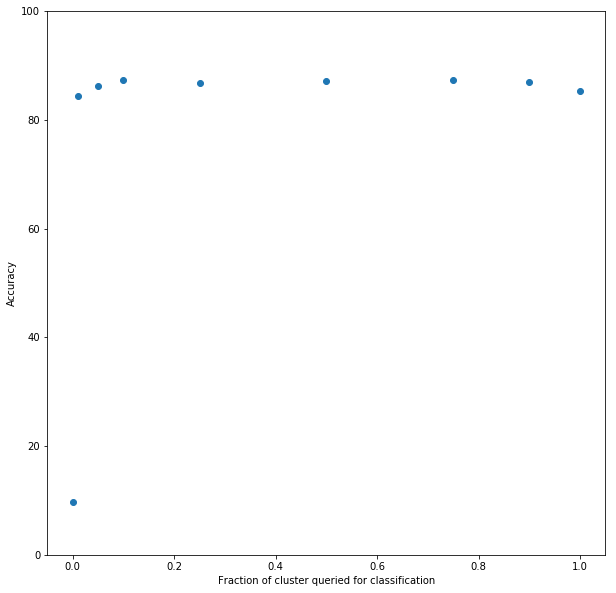

In [103]:
fig = plt.figure(figsize=(10,10))
plt.plot(fractions, accs, 'o')
plt.xlabel('Fraction of cluster queried for classification')
plt.ylabel('Accuracy')
plt.xlim(-0.05,1.05)
plt.ylim(0,100)
plt.show()

The performance very quickly converges at 10%.  Assuming perfect volunteer performance, querying only 10% of a cluster leads to similar performance as querying all examples in a cluster for the dominant cluster class.  (The variation in performance beyond a fraction of 0.1 is due to the stochastic nature of the CNN training.)